# Notes
- uses the new dataset (correct one)
- has two versions
- pickles everything
- tests on new dataset

In [1]:
import numpy as np
import pandas as pd

import sqlite3
from sqlite3 import Error

import matplotlib.pyplot as plt
import seaborn as sns

import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder

from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from joblib import dump, load

In [2]:
db_path = "../../dbs/delays_new.db"

In [3]:
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        connection.text_factory = str
    except Error as e:
        print("Error occurred: " + str(e))
    return connection


def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        if query == "":
            return "Query Blank"
        else:
            df = pd.read_sql_query(query, connection)
            return df
    except Error as e:
        return "Error occurred: " + str(e)

In [4]:
def preprocess_inputs(df, use_departure_delay):
    
    df = df.copy()
    
    categorical_features = ['IATA_CODE_Reporting_Airline', 'OriginAirportID', 'DestAirportID', 'Month', 'DayofMonth', 'DayOfWeek', 'DepHour']
    
    if (not use_departure_delay):
        df = df.drop('DepDelay', axis=1)
    
    y = (df.ArrDelay>15).astype(int)
    X = df.drop('ArrDelay', axis=1)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

    categorical_train = X_train[categorical_features]
    
    one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
    one_hot_encoder.fit(categorical_train)

    encoded_train = pd.DataFrame(data=one_hot_encoder.transform(categorical_train).toarray(), columns=one_hot_encoder.get_feature_names_out(categorical_features), dtype=int)
    X_train = X_train.drop(categorical_features, axis=1).reset_index(drop=True)
    X_train = X_train.join(encoded_train)
        
    categorical_test = X_test[categorical_features]
    
    encoded_test = pd.DataFrame(data=one_hot_encoder.transform(categorical_test).toarray(), columns=one_hot_encoder.get_feature_names_out(categorical_features), dtype=int)
    X_test = X_test.drop(categorical_features, axis=1).reset_index(drop=True)
    X_test = X_test.join(encoded_test)
    
    smote = SMOTE()
    X_train, y_train = smote.fit_resample(X_train, y_train)
   
    # Scale X with a standard scaler
    standard_scaler = StandardScaler()
    standard_scaler.fit(X_train)
    
    
    X_train = pd.DataFrame(standard_scaler.transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(standard_scaler.transform(X_test), columns=X_test.columns)
   
    return X_train, X_test, y_train, y_test

In [5]:
def evaluate_model(name, model, X_test, y_test):
    
    model_acc = model.score(X_test, y_test)
    
    print("\n"+name)
    print("Test Accuracy: {:.2f}%".format(model_acc * 100))
    
    y_true = np.array(y_test)
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_true, y_pred)
    clr = classification_report(y_true, y_pred, target_names=["Not Delayed", "Delayed"])
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(2) + 0.5, ["Not Delayed", "Delayed"])
    plt.yticks(np.arange(2) + 0.5, ["Not Delayed", "Delayed"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

In [6]:
sample_query = \
    """
        select 
         Month,
         DayofMonth,
         DayOfWeek,
         SUBSTR(CRSDepTime, 1, LENGTH(CRSDepTime)-2) as DepHour,
         IATA_CODE_Reporting_Airline,
         OriginAirportID,
         DestAirportID,
         AirTime,
         DepDelay,
         ArrDelay
        from 
          delay
         where Cancelled = 0  
         and AirTime > 0 
         and Year=2019
         and Month=1
        order by RANDOM() LIMIT 10000
    """

connection = create_connection(db_path)
data =  execute_query(connection, sample_query)

In [7]:
X_train, X_test, y_train, y_test = preprocess_inputs(data, use_departure_delay=False)


Nearest Neighbors
Test Accuracy: 60.55%


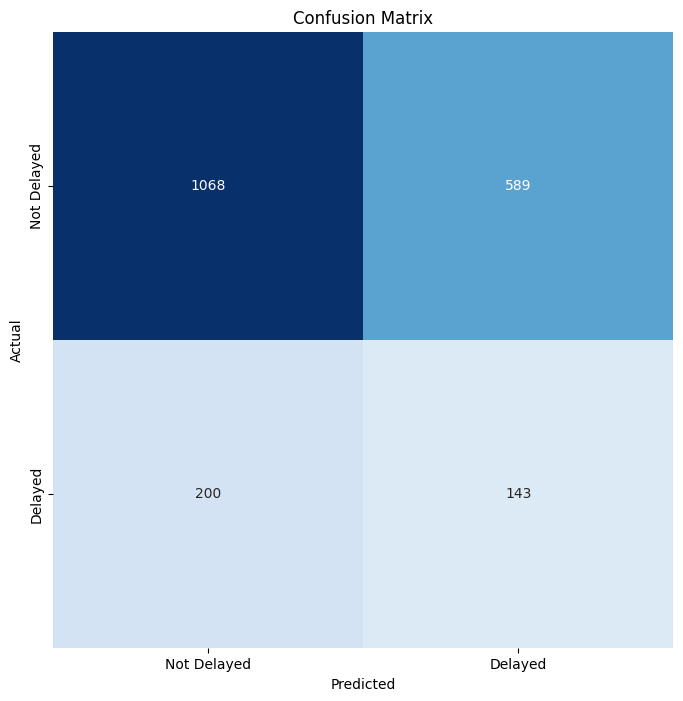

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.84      0.64      0.73      1657
     Delayed       0.20      0.42      0.27       343

    accuracy                           0.61      2000
   macro avg       0.52      0.53      0.50      2000
weighted avg       0.73      0.61      0.65      2000


Linear SVM
Test Accuracy: 82.50%


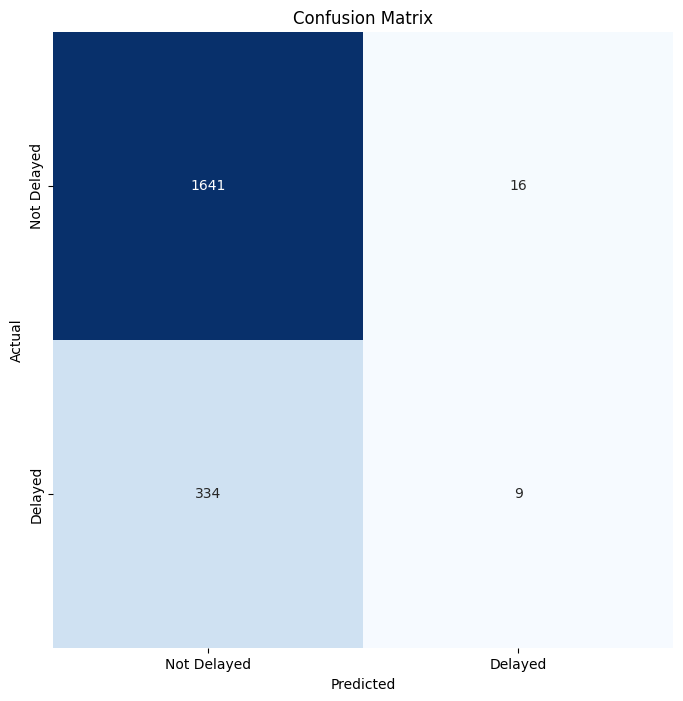

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.83      0.99      0.90      1657
     Delayed       0.36      0.03      0.05       343

    accuracy                           0.82      2000
   macro avg       0.60      0.51      0.48      2000
weighted avg       0.75      0.82      0.76      2000


RBF SVM
Test Accuracy: 82.85%


/Users/ayushsubedi/Desktop/learn/fp/env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ayushsubedi/Desktop/learn/fp/env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ayushsubedi/Desktop/learn/fp/env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

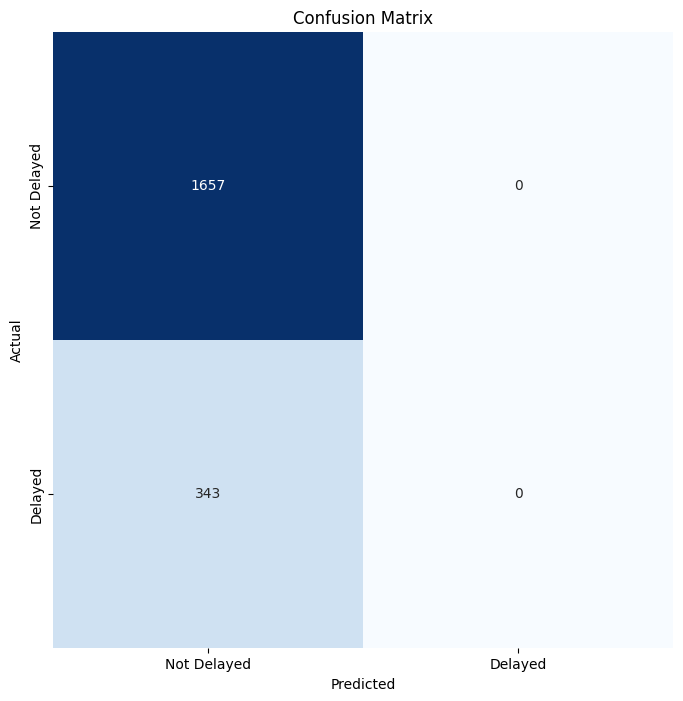

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.83      1.00      0.91      1657
     Delayed       0.00      0.00      0.00       343

    accuracy                           0.83      2000
   macro avg       0.41      0.50      0.45      2000
weighted avg       0.69      0.83      0.75      2000


Gaussian Process
Test Accuracy: 81.25%


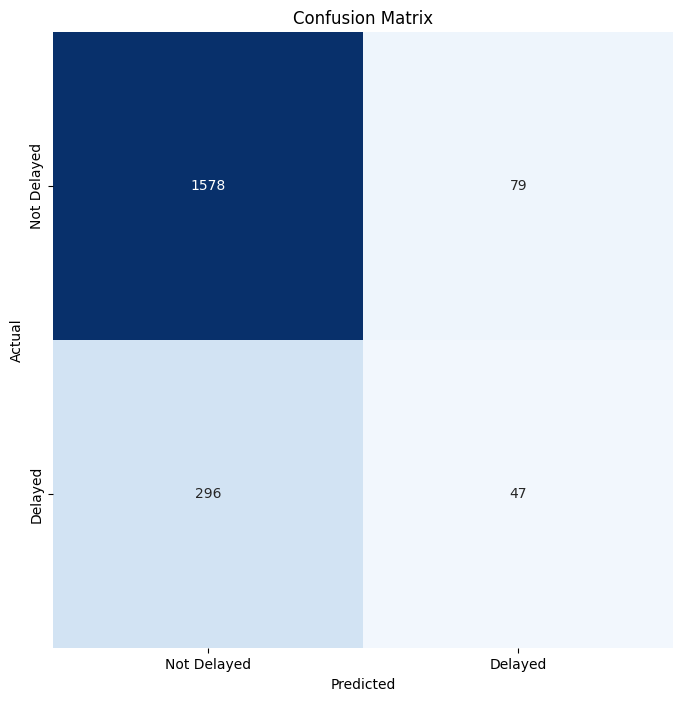

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.84      0.95      0.89      1657
     Delayed       0.37      0.14      0.20       343

    accuracy                           0.81      2000
   macro avg       0.61      0.54      0.55      2000
weighted avg       0.76      0.81      0.77      2000


Decision Tree
Test Accuracy: 55.15%


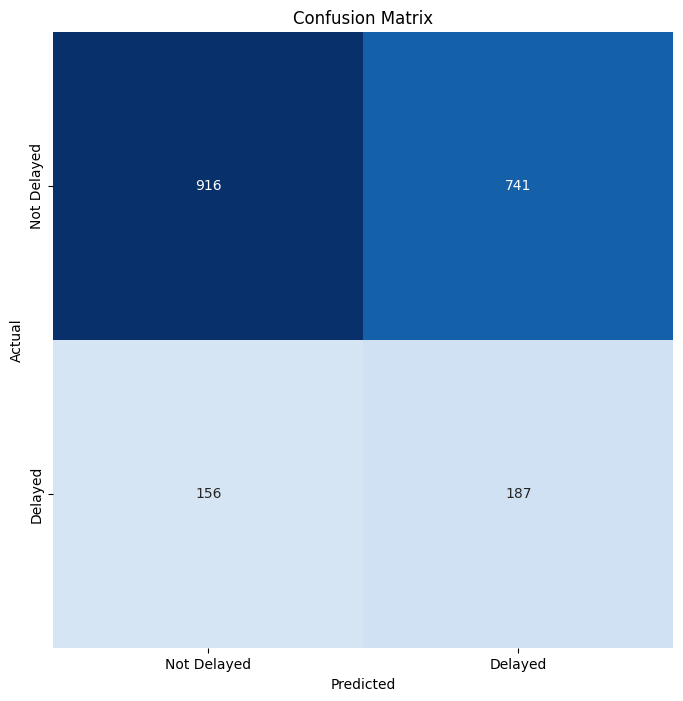

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.85      0.55      0.67      1657
     Delayed       0.20      0.55      0.29       343

    accuracy                           0.55      2000
   macro avg       0.53      0.55      0.48      2000
weighted avg       0.74      0.55      0.61      2000


Random Forest
Test Accuracy: 35.95%


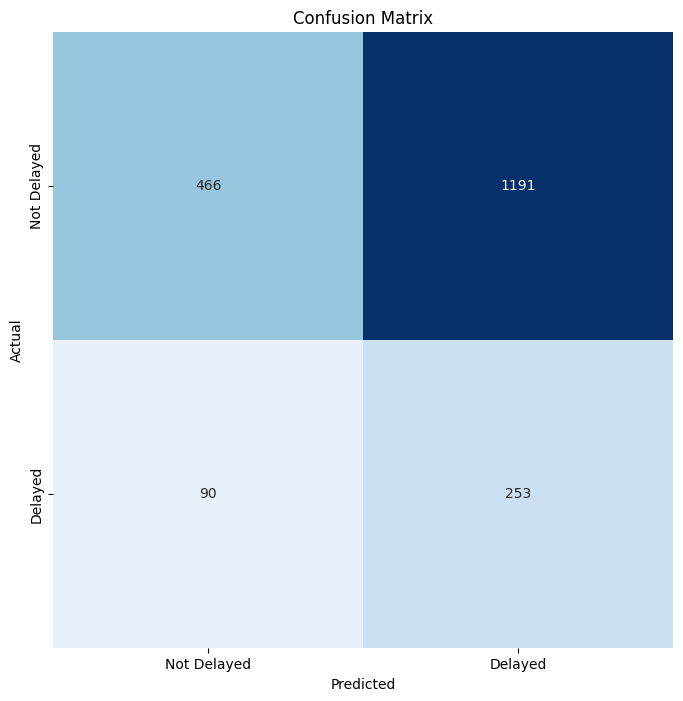

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.84      0.28      0.42      1657
     Delayed       0.18      0.74      0.28       343

    accuracy                           0.36      2000
   macro avg       0.51      0.51      0.35      2000
weighted avg       0.72      0.36      0.40      2000


Neural Net
Test Accuracy: 79.80%


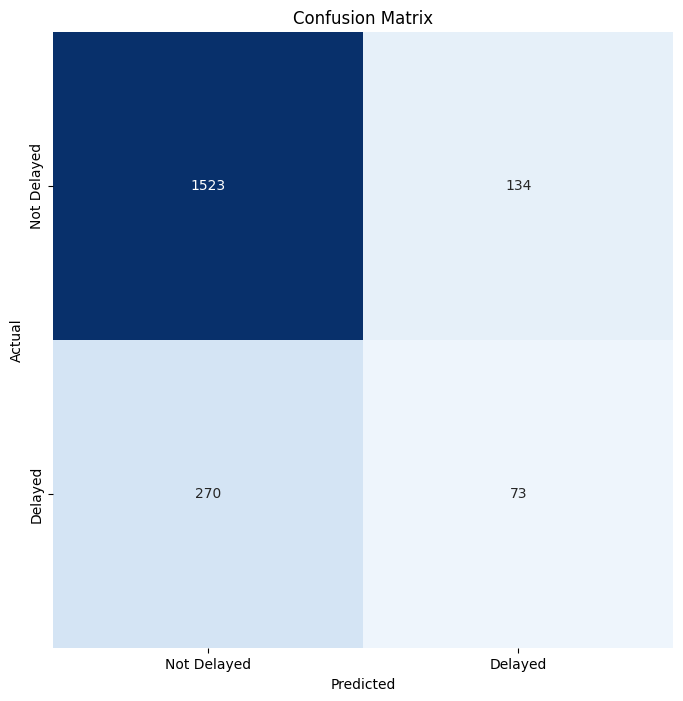

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.85      0.92      0.88      1657
     Delayed       0.35      0.21      0.27       343

    accuracy                           0.80      2000
   macro avg       0.60      0.57      0.57      2000
weighted avg       0.76      0.80      0.78      2000


AdaBoost
Test Accuracy: 80.70%


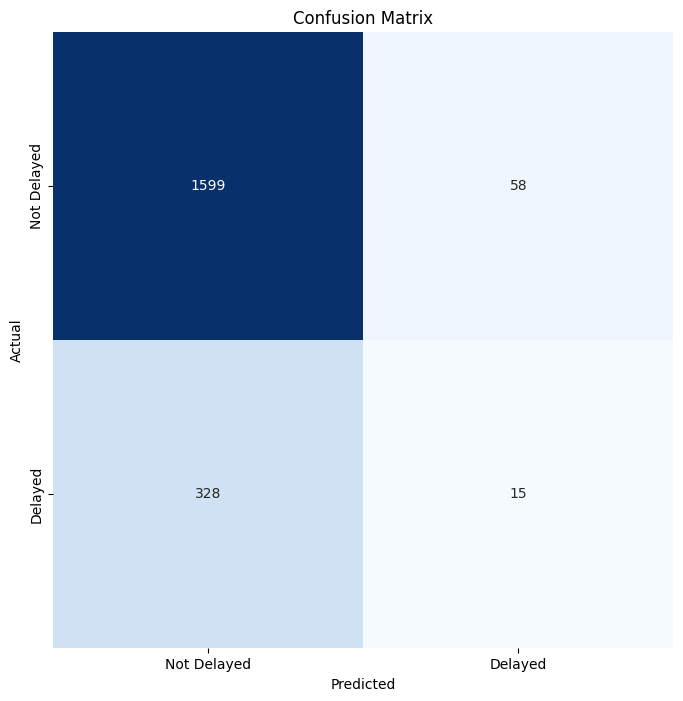

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.83      0.96      0.89      1657
     Delayed       0.21      0.04      0.07       343

    accuracy                           0.81      2000
   macro avg       0.52      0.50      0.48      2000
weighted avg       0.72      0.81      0.75      2000


Naive Bayes
Test Accuracy: 26.35%


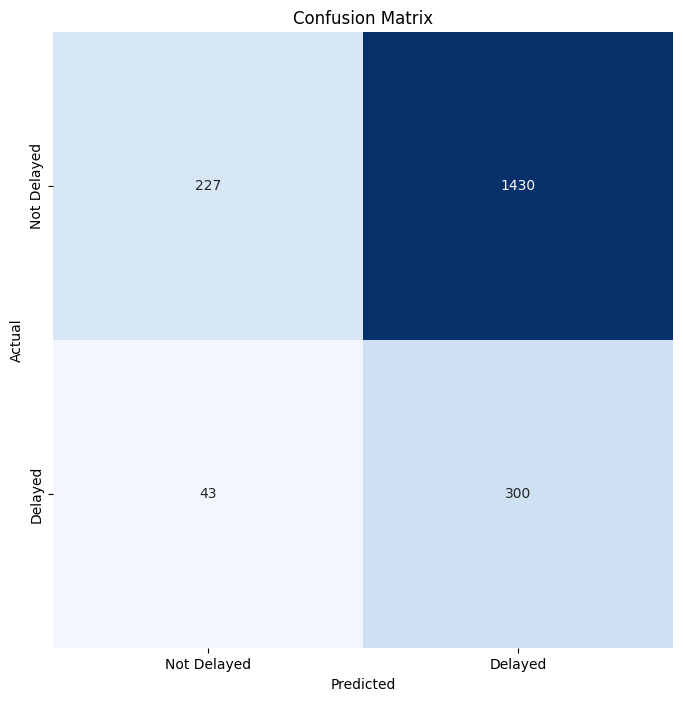

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.84      0.14      0.24      1657
     Delayed       0.17      0.87      0.29       343

    accuracy                           0.26      2000
   macro avg       0.51      0.51      0.26      2000
weighted avg       0.73      0.26      0.24      2000



/Users/ayushsubedi/Desktop/learn/fp/env/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")



QDA
Test Accuracy: 55.20%


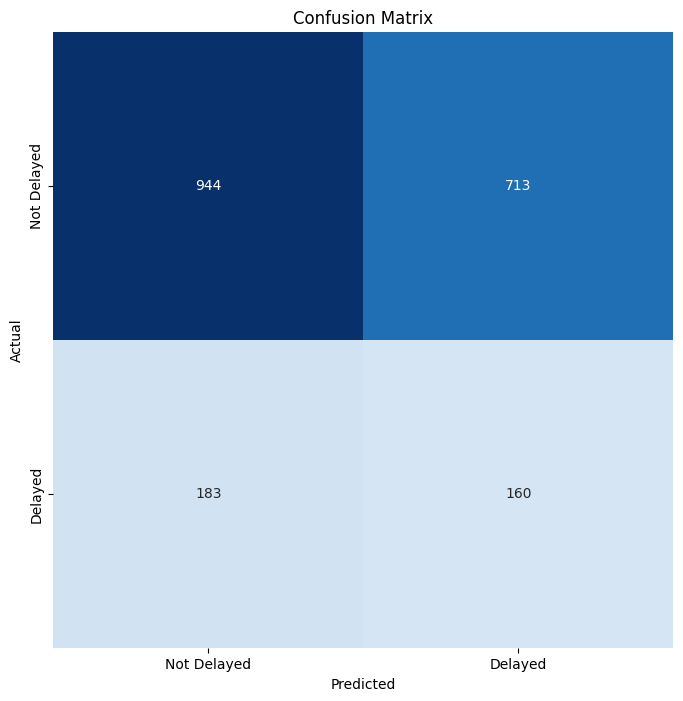

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.84      0.57      0.68      1657
     Delayed       0.18      0.47      0.26       343

    accuracy                           0.55      2000
   macro avg       0.51      0.52      0.47      2000
weighted avg       0.73      0.55      0.61      2000



In [8]:


names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]


# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    evaluate_model(name, clf, X_test, y_test)


In [9]:
X_train, X_test, y_train, y_test = preprocess_inputs(data, use_departure_delay=True)


Nearest Neighbors
Test Accuracy: 66.95%


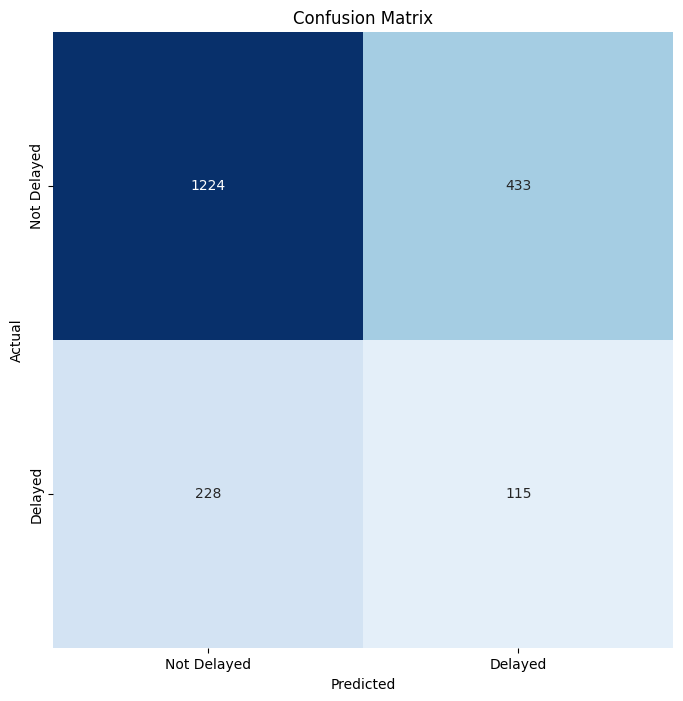

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.84      0.74      0.79      1657
     Delayed       0.21      0.34      0.26       343

    accuracy                           0.67      2000
   macro avg       0.53      0.54      0.52      2000
weighted avg       0.73      0.67      0.70      2000


Linear SVM
Test Accuracy: 91.65%


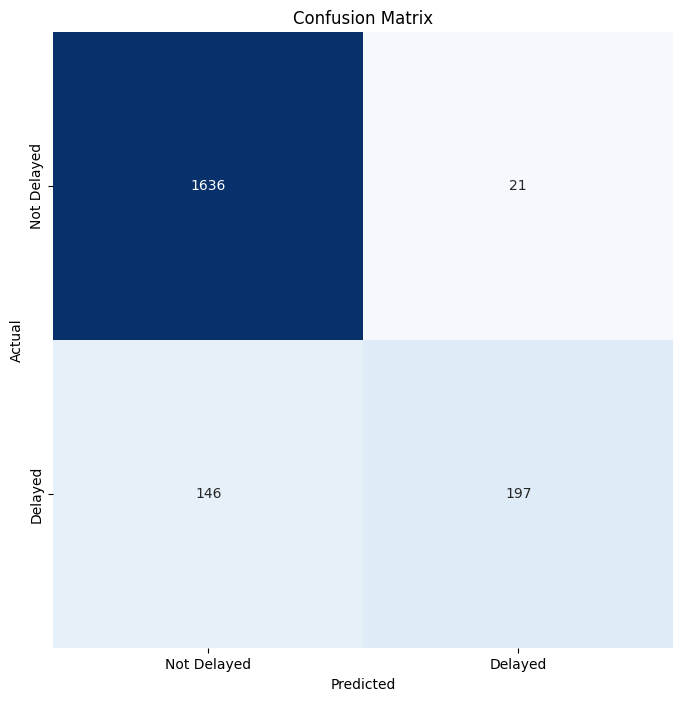

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.92      0.99      0.95      1657
     Delayed       0.90      0.57      0.70       343

    accuracy                           0.92      2000
   macro avg       0.91      0.78      0.83      2000
weighted avg       0.92      0.92      0.91      2000


RBF SVM
Test Accuracy: 82.85%


/Users/ayushsubedi/Desktop/learn/fp/env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ayushsubedi/Desktop/learn/fp/env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ayushsubedi/Desktop/learn/fp/env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

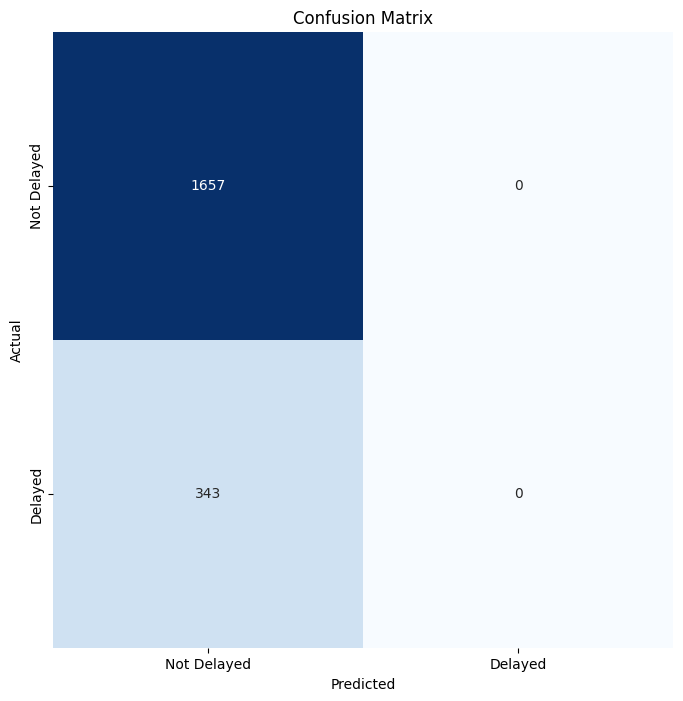

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.83      1.00      0.91      1657
     Delayed       0.00      0.00      0.00       343

    accuracy                           0.83      2000
   macro avg       0.41      0.50      0.45      2000
weighted avg       0.69      0.83      0.75      2000



In [ ]:


names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]


# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    evaluate_model(name, clf, X_test, y_test)
